In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm


In [2]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


value_to_predict = 'Sex'

In [3]:
transcripts_dict = {}
transcripts_list = []
for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    transcripts_dict[organ] = {}

    for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
        features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
        features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

        transcripts_dict[organ][sex] = features_list.index
        
        transcripts_list.extend(features_list.index.tolist())
        # print(features_list)
transcripts_list = list(set(transcripts_list))

In [4]:
transcripts_dict
transcripts_list

['MSTRG.34956.7',
 'MSTRG.32512.1',
 'MSTRG.17871.5',
 'ENST00000246080.4',
 'ENST00000607443.1',
 'MSTRG.22356.8',
 'ENST00000645586.1',
 'MSTRG.3529.27',
 'MSTRG.31525.1',
 'MSTRG.20210.2',
 'ENST00000372583.6',
 'ENST00000400246.7',
 'ENST00000548200.5',
 'MSTRG.8485.2',
 'ENST00000548305.5',
 'ENST00000390539.2',
 'MSTRG.3806.9',
 'MSTRG.34322.14',
 'ENST00000367718.5',
 'MSTRG.14356.1',
 'ENST00000556181.1',
 'MSTRG.1857.1',
 'ENST00000280187.11',
 'MSTRG.17052.1',
 'MSTRG.3823.12',
 'MSTRG.28032.1',
 'MSTRG.1873.42',
 'ENST00000645860.1',
 'ENST00000543841.5',
 'MSTRG.12951.1',
 'MSTRG.17323.5',
 'MSTRG.36020.14',
 'ENST00000624344.1',
 'ENST00000468138.5',
 'ENST00000582019.5',
 'ENST00000479214.5',
 'MSTRG.14143.25',
 'MSTRG.16471.18',
 'ENST00000552516.5',
 'ENST00000375200.6',
 'ENST00000675525.1',
 'ENST00000372987.8',
 'ENST00000418346.1',
 'ENST00000426395.7',
 'ENST00000337338.9',
 'ENST00000602495.1',
 'MSTRG.22373.18',
 'ENST00000530439.1',
 'ENST00000620613.1',
 'MSTRG

In [5]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

# example = generate_counts()
# plot(example)
# example

In [6]:
import itertools

for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    transcripts_dict[organ]['chrXY']

# for key1, key2 in list(itertools.combinations(['BRAIN0', "HEART", "BRAIN1", 'None'], 2)):
#     transcripts_dict[key1]['chrXY'].union(transcripts_dict[key2]['chrXY'])



Chromosomes:  autosome
['BRAIN0'] : 
{'MSTRG.34956.7', 'ENST00000460903.2', 'MSTRG.11948.25', 'MSTRG.4655.1', 'ENST00000607443.1', 'ENST00000702378.1', 'ENST00000537488.1', 'MSTRG.11536.33', 'MSTRG.830.1', 'MSTRG.5819.3', 'ENST00000592148.1', 'MSTRG.22088.31', 'ENST00000462190.1', 'MSTRG.35088.43', 'ENST00000491215.1', 'ENST00000564079.6', 'MSTRG.28865.25', 'ENST00000670600.1', 'ENST00000552516.5', 'ENST00000298630.8'}
['BRAIN1' 'None'] : 
{'MSTRG.32512.1', 'MSTRG.33150.3'}
['HEART' 'None'] : 
{'MSTRG.2758.7', 'ENST00000553708.5', 'ENST00000587012.1', 'MSTRG.17882.17', 'MSTRG.16471.18', 'MSTRG.17871.5', 'ENST00000368680.4', 'ENST00000360428.9', 'ENST00000543072.2', 'ENST00000441002.1', 'MSTRG.1913.3', 'MSTRG.1727.13', 'ENST00000358747.10', 'ENST00000477689.2'}
['BRAIN0' 'HEART' 'BRAIN1' 'None'] : 
{'ENST00000581584.5', 'ENST00000494573.6', 'ENST00000413366.8', 'MSTRG.5179.5', 'ENST00000246080.4', 'ENST00000372583.6', 'MSTRG.26990.1', 'ENST00000548200.5', 'ENST00000589005.5', 'ENST00000

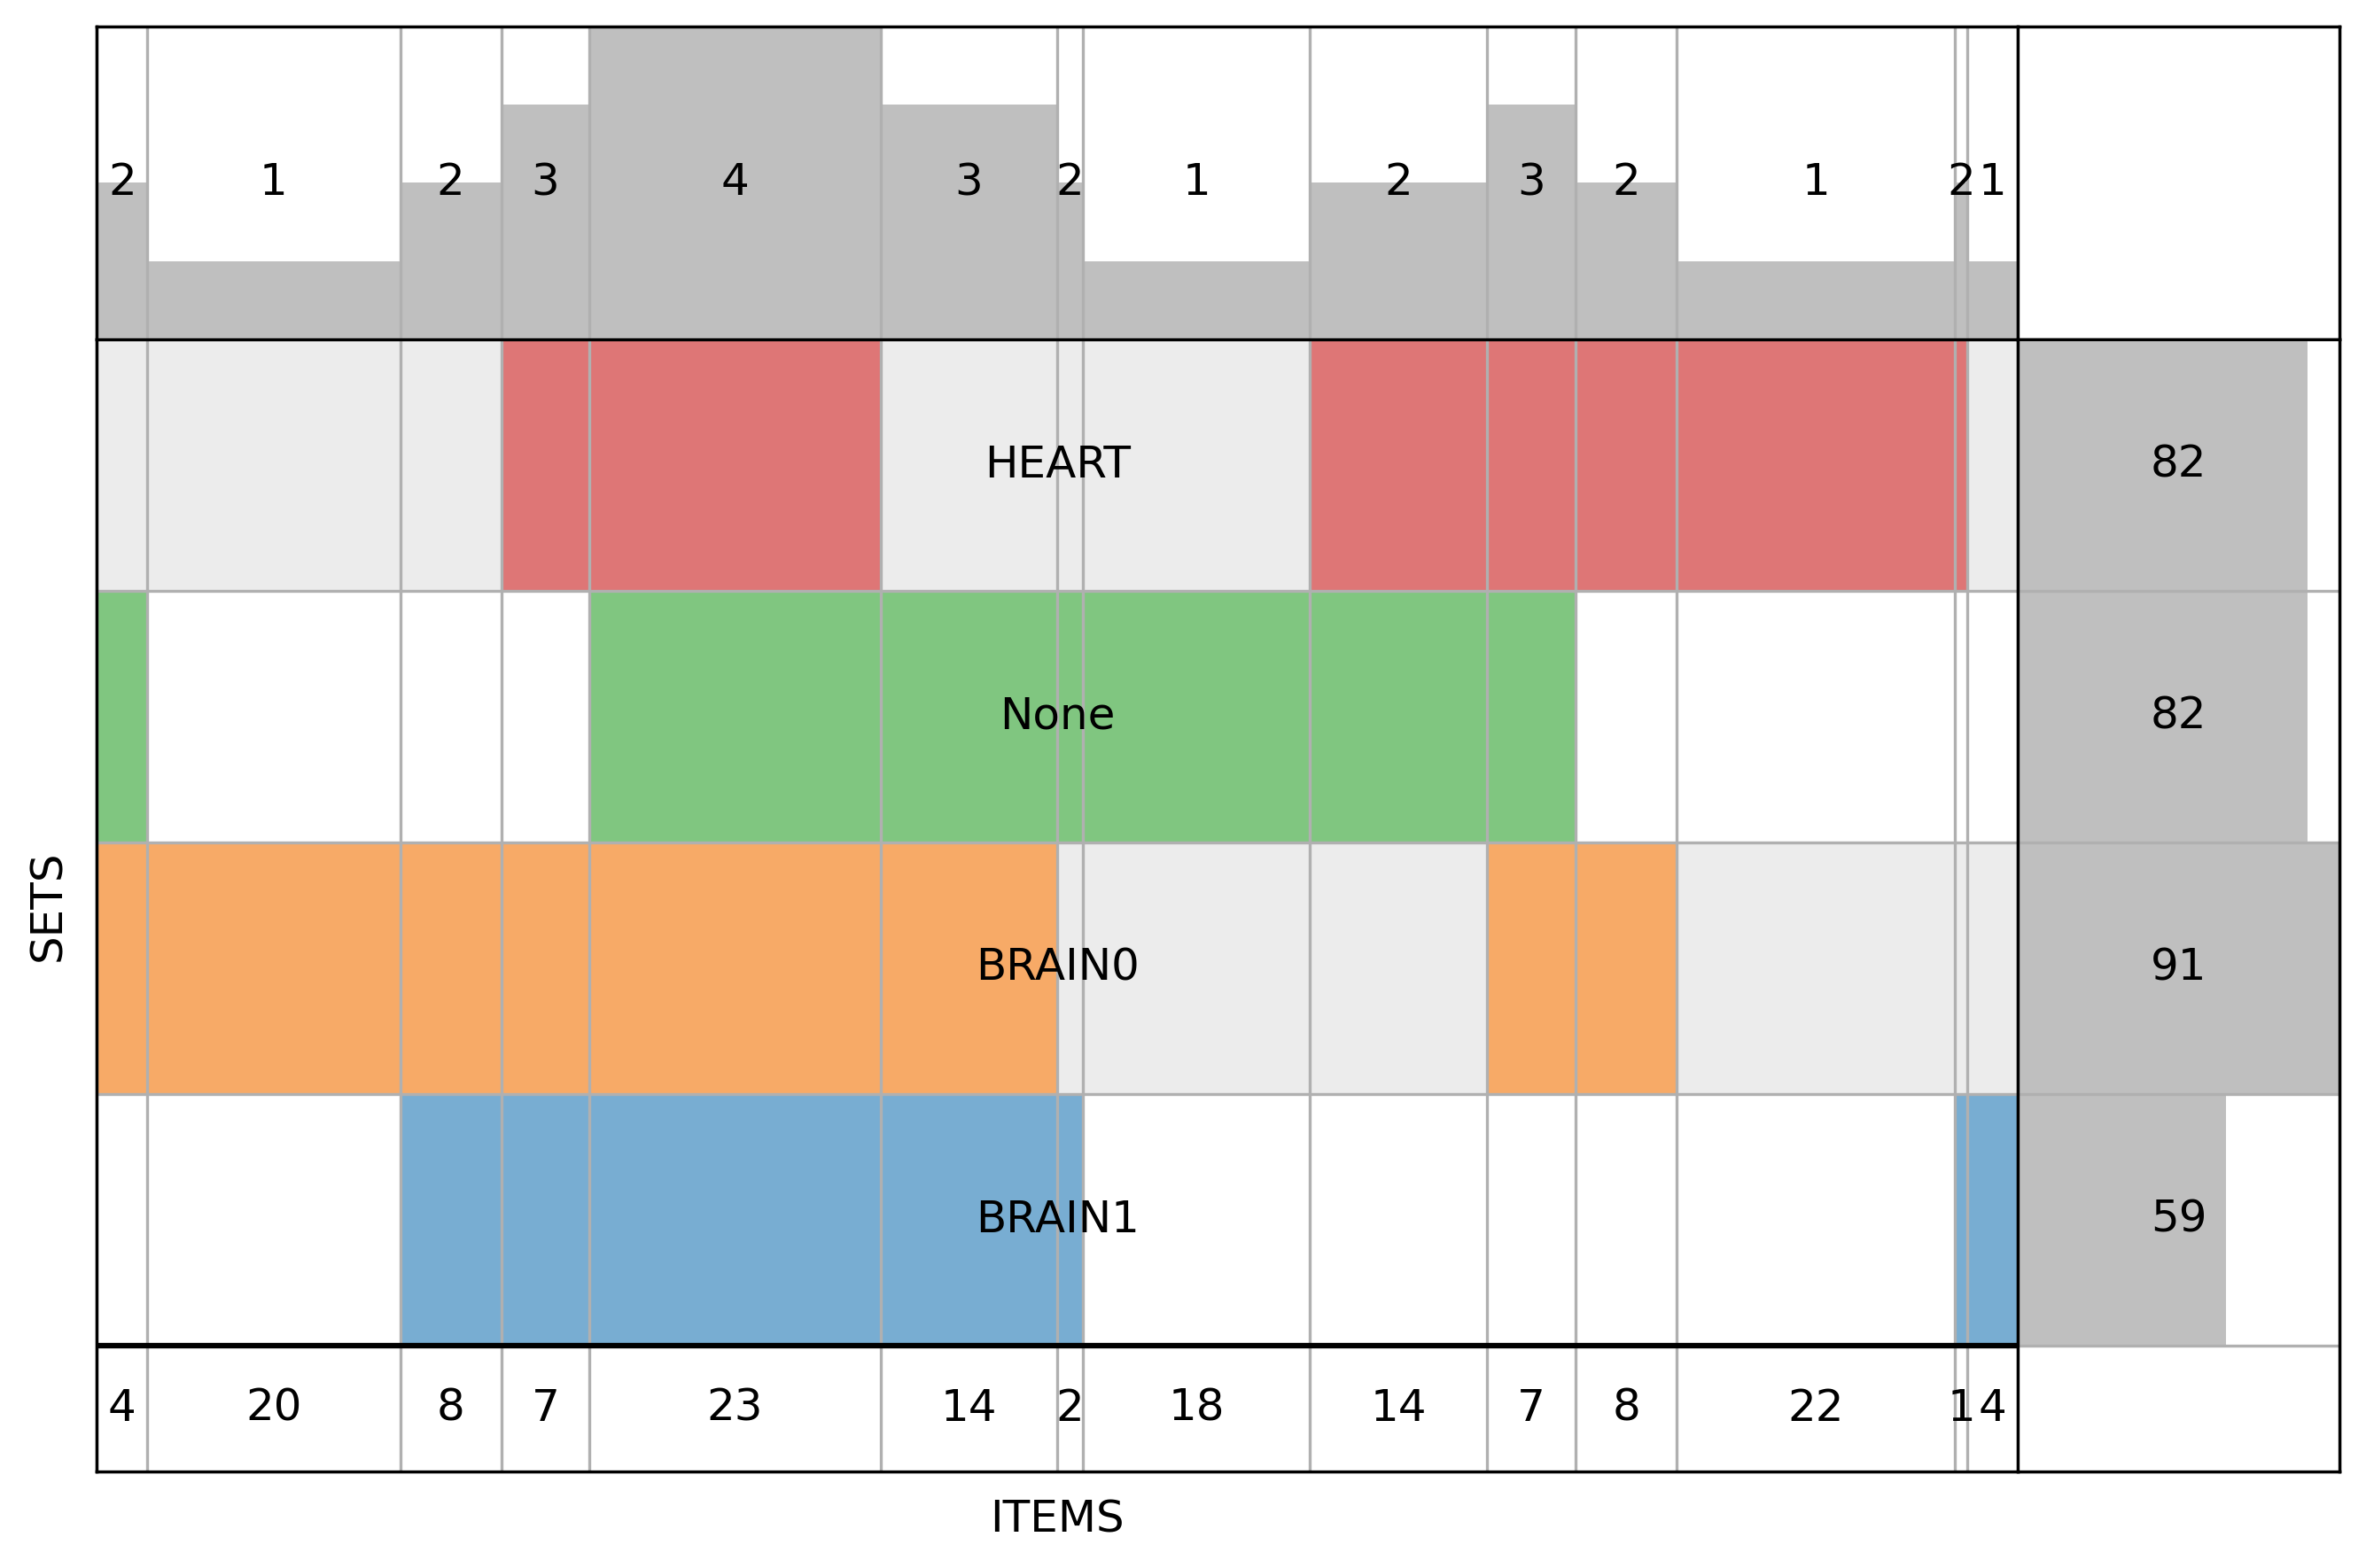

In [7]:
# chrXY_df = {
#     # "names": transcripts_list,
#     'BRAIN0': [],
#     'HEART': [], 
#     'BRAIN1': [],
#     'None': []
#     }
# fig, axs= plt.subplots()
# for transcript in transcripts_list:
#     for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
        
#         if transcript in transcripts_dict[organ]['chrXY']:
#             chrXY_df[organ].append(True)
#         else:
#             chrXY_df[organ].append(False)
# chrXY_df = pd.DataFrame.from_dict(chrXY_df)
# 
# UpSet(chrXY_df, subset_size='count').plot()

# for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:

sex = ['chrXY', 'chrX', 'chrY', 'autosome'][3]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    test_dict[organ] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


Organ:  BRAIN1
['autosome'] : 
{'ENST00000581584.5', 'ENST00000466335.1', 'ENST00000494573.6', 'ENST00000413366.8', 'MSTRG.5179.5', 'MSTRG.32512.1', 'ENST00000493260.5', 'MSTRG.14482.3', 'MSTRG.11500.1', 'ENST00000246080.4', 'MSTRG.14706.28', 'ENST00000507765.1', 'MSTRG.3529.27', 'MSTRG.20210.2', 'MSTRG.26990.1', 'ENST00000372583.6', 'MSTRG.6368.4', 'MSTRG.23169.2', 'ENST00000548200.5', 'ENST00000303115.8', 'ENST00000651342.1', 'ENST00000548305.5', 'MSTRG.16726.28', 'ENST00000589005.5', 'ENST00000476438.1', 'MSTRG.20714.15', 'MSTRG.3806.9', 'MSTRG.12050.13', 'MSTRG.1168.1', 'MSTRG.29554.27', 'ENST00000357450.9', 'MSTRG.13450.7', 'MSTRG.23851.1', 'ENST00000565196.5', 'MSTRG.1857.1', 'ENST00000280187.11', 'MSTRG.21438.5', 'ENST00000684774.1', 'MSTRG.33150.3', 'MSTRG.20911.32', 'MSTRG.3823.12', 'MSTRG.28032.1', 'ENST00000372476.8', 'MSTRG.34381.1', 'ENST00000624344.1', 'ENST00000582019.5', 'MSTRG.427.3', 'MSTRG.27773.6', 'MSTRG.21565.11', 'MSTRG.17797.1', 'ENST00000308831.7', 'MSTRG.1141.

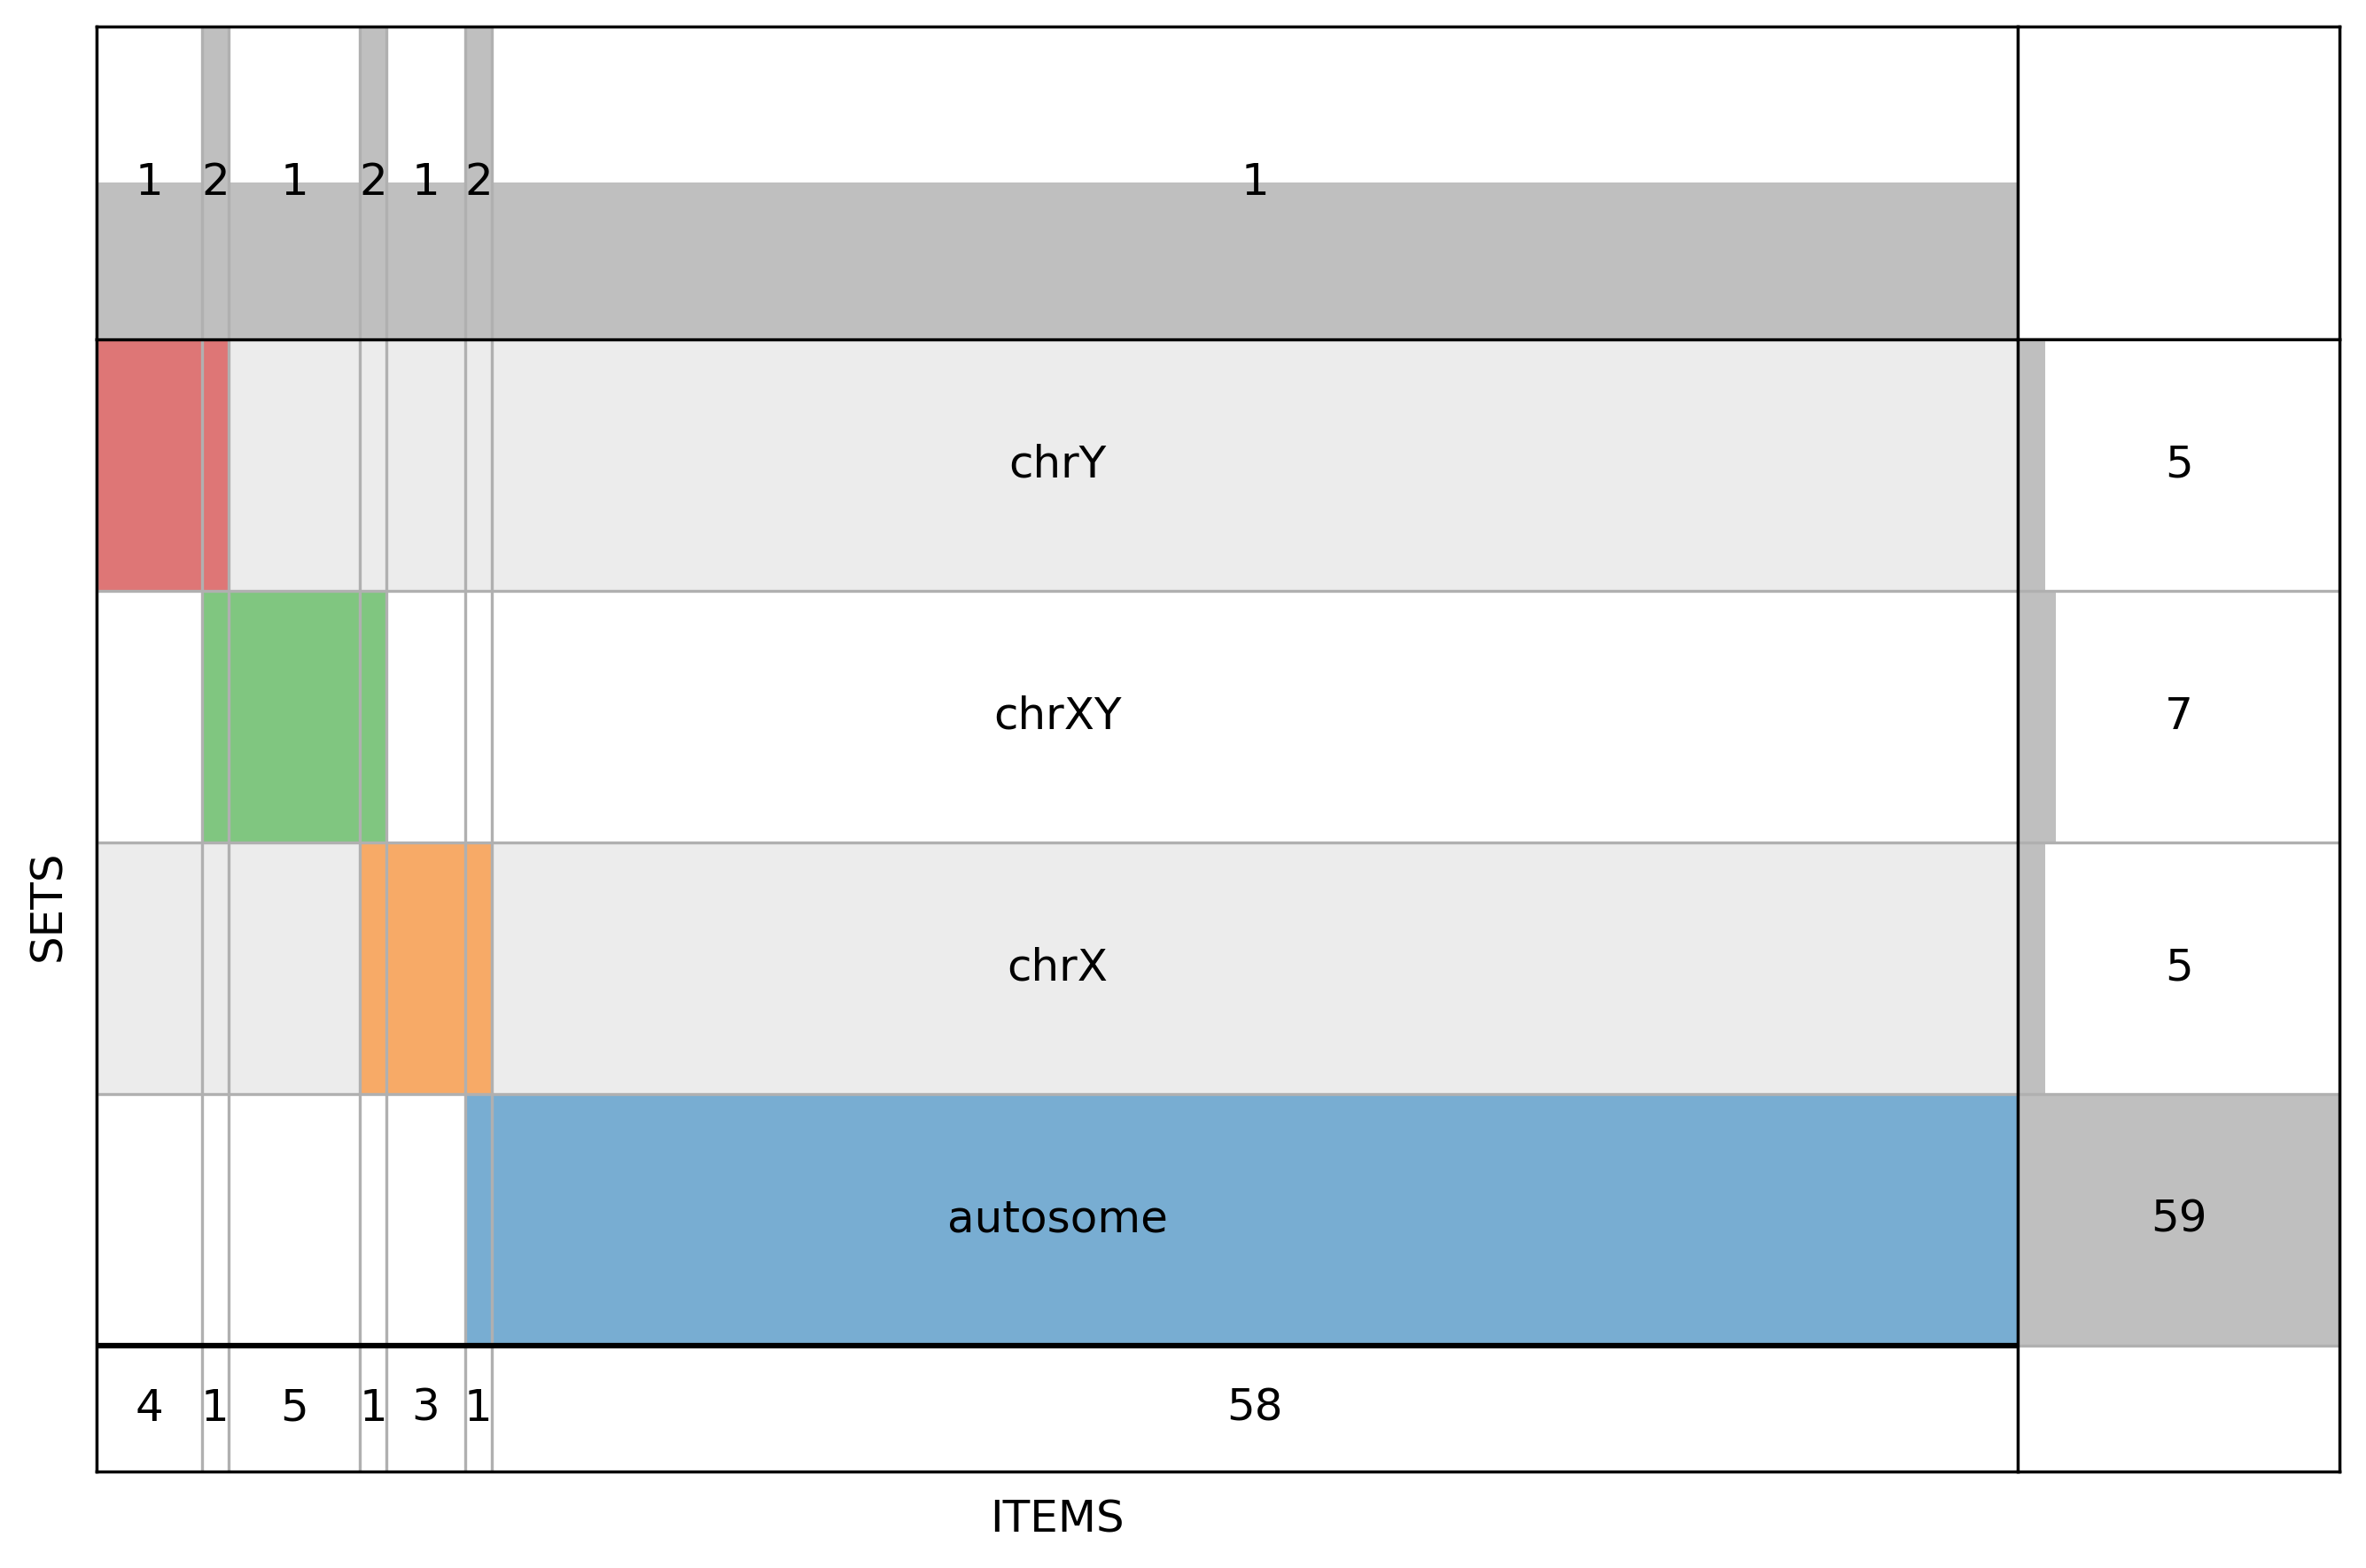

In [16]:
organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][2]
test_dict = {}
for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    test_dict[sex] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])

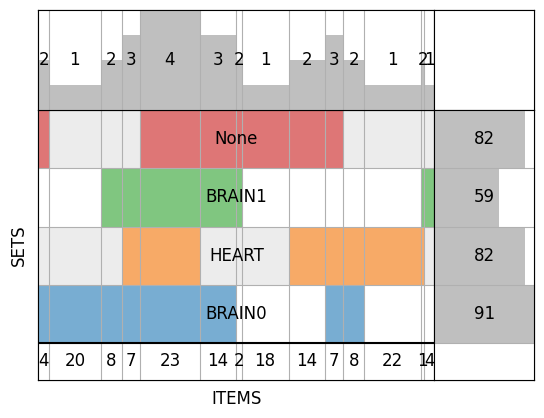

In [8]:
g = supervenn(list(test_dict.values()), list(test_dict.keys()), 
              sets_ordering=None)

In [9]:
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)])

['BRAIN0']
['BRAIN1' 'None']
['HEART' 'None']
['BRAIN0' 'HEART' 'BRAIN1' 'None']
['BRAIN0' 'HEART' 'BRAIN1']
['None']
['BRAIN0' 'BRAIN1' 'None']
['HEART']
['BRAIN0' 'BRAIN1']
['BRAIN0' 'HEART' 'None']
['BRAIN0' 'HEART']
['BRAIN0' 'None']
['BRAIN1']
['HEART' 'BRAIN1']


In [10]:
np.array(list(test_dict.keys()))

array(['BRAIN0', 'HEART', 'BRAIN1', 'None'], dtype='<U6')